In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

#### Experiment Setup
Because I want to investigate the effect of 3pt shooting after GSW won their championship. I will only look at data after 2015 onward.

#### Motivation
Since the Golden State Warriors, led by superstar Stephen Curry, won their NBA championship in 2015, there has been a increase in 3-pt shooting in the games. We now know that 3-pt shooting team can win championship, but we might want to know how important it is to have a high team 3-pt field goal percentage in order to win games.

In [2]:
df = pd.read_csv('data/games.csv')
df = df[df.SEASON > 2014]
df.head()

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2020-12-19,12000047,Final,1610612753,1610612766,2020,1610612753,120.0,0.433,0.792,...,23.0,50.0,1610612766,117.0,0.444,0.864,0.439,21.0,52.0,1
1,2020-12-19,12000048,Final,1610612764,1610612765,2020,1610612764,99.0,0.427,0.625,...,24.0,45.0,1610612765,96.0,0.402,0.647,0.326,18.0,51.0,1
2,2020-12-19,12000049,Final,1610612763,1610612737,2020,1610612763,116.0,0.400,0.744,...,21.0,43.0,1610612737,117.0,0.422,0.837,0.297,24.0,47.0,0
3,2020-12-18,12000039,Final,1610612754,1610612755,2020,1610612754,107.0,0.371,0.692,...,19.0,45.0,1610612755,113.0,0.533,0.629,0.355,23.0,48.0,0
4,2020-12-18,12000040,Final,1610612761,1610612748,2020,1610612761,105.0,0.380,0.737,...,27.0,37.0,1610612748,117.0,0.534,0.741,0.514,30.0,51.0,0


#### Creation of treatment and control group:

Treatment group includes data where a team won given it has higher 3pt field goal percentage (3pt-fg) than the other team
Control group includes data where a team won given it has lower or equal 3pt field goal percentage (3pt-fg) than the other team

In [3]:
df = df[['FG3_PCT_home','FG3_PCT_away','HOME_TEAM_WINS']]
df['HOME_3PT'] = (df.FG3_PCT_home > df.FG3_PCT_away)*1
df

,FG3_PCT_home,FG3_PCT_away,HOME_TEAM_WINS,HOME_3PT
0,0.425,0.439,1,0
1,0.295,0.326,1,0
2,0.396,0.297,0,1
3,0.262,0.355,0,0
4,0.356,0.514,0,0
...,...,...,...,...
22097,0.182,0.333,1,0
22098,0.261,0.133,0,1
22099,0.231,0.387,0,0
22100,0.286,0.344,0,0


Treatment:
- there are 4826 instance in the treatment group
- Proportion of instance where a team that has a higher 3pt-fg than its opponent won is 56.75%

In [4]:
# (higher 3pt)
treatment = df.query("(HOME_TEAM_WINS == 1 & HOME_3PT == 1) | (HOME_TEAM_WINS == 0 & HOME_3PT == 0)")
print(treatment.shape[0])
n_treatment = (treatment['HOME_TEAM_WINS'] == 1).sum()
p_obs_treatment = n_treatment/treatment.shape[0]
p_obs_treatment

4826


0.5675507666804808

Control:
- there are 2045 instance in the control group
- Proportion of instance where a team that has a lower or same 3pt-fg than its opponent won is 59.8%

In [5]:
# (lower/equal 3pt)
control = df.query("(HOME_TEAM_WINS == 0 & HOME_3PT == 1) | (HOME_TEAM_WINS == 1 & HOME_3PT == 0)")
print(control.shape[0])
n_control = (control['HOME_TEAM_WINS'] == 1).sum()
p_obs_control = n_control/control.shape[0]
p_obs_control

2045


0.5980440097799511

### A/B Test
Assuming I have to consider the question whether higher team 3pt-fg percentage wins more games based on the observation data we obtained only at a Type I error rate of 5%, what would the null hypothesis be?

#### Hypothsis Test
- $H_0$ = Higher team 3pt-fg percentage does not win more games. `P_higher_3pt_win - P_not_higher_win = 0`
- $H_1$ = Higher team 3pt-fg percentage wins more games. `P_higher_3pt_win > P_not_higher_win`

For this A/B test, under the assumption that $H_0 = true$, we want to know whether higher team 3pt-fg percentage wins more games?

We will use bootstrapping to simulate 10,000 samples. And for each of them, we will measure the difference of `P_higher_3pt_win` and `P_not_higher_win`

In [7]:
p_diffs = []
for _ in range(10000):
    higher_3pt_win = np.random.binomial(1,p_obs_treatment,treatment.shape[0])
    not_higher_win = np.random.binomial(1,p_obs_control,control.shape[0])
    p_diffs.append(higher_3pt_win.mean() - not_higher_win.mean())

`p_obs_diff` is the difference of `P_higher_3pt_win` and `P_not_higher_win` of our observation data above

In [8]:
p_obs_diff = p_obs_treatment - p_obs_control
p_obs_diff

-0.030493243099470324

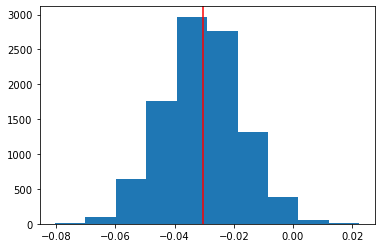

In [9]:
p_diffs = np.array(p_diffs)
plt.hist(p_diffs)
plt.axvline(x = p_obs_diff,c='red')
plt.show()

At a Type I error rate of 5%, p-value is larger than the error rate, and therefore we **fail to reject** the Null hypothesis. There is a probability of 50.34% that team will lower or equal 3pt-fg as the opponent team wins the game.

In [10]:
p_value = (p_diffs > p_obs_diff).mean()
p_value

0.4954